# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver
from matplotlib import pyplot as plt
import time


import numpy as np

from utils import create_random_circle_object, plot_probes, plot_forward_results

PETSc4Py is not installed. PWEPetscFullPinTSolver will not work without it.


### Simulated Probe Configuration

In [2]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=0.635e-6,  # meters (0.635 μm). Visible light
    diameter=5e-6,  # [m]
    focus=-3e-6,  # focal length [m]
    # tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

### Discretization Parameters and Spatial Limits

In [3]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 20
pad_factor = 2.5  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = True

# Thickness Discretization (Pixels)
points_per_wavelength = 8
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

### Simulation Config

2025-12-12 14:23:39,214 - INFO - === Scan Summary ===
2025-12-12 14:23:39,216 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-12 14:23:39,219 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-12 14:23:39,220 - INFO -   Sample Pixels:          3001 px
2025-12-12 14:23:39,222 - INFO -   Step size:              20 px
2025-12-12 14:23:39,223 - INFO -   Number of scan points:  60
2025-12-12 14:23:39,229 - INFO -   Steps in z:             503
2025-12-12 14:23:39,231 - INFO -   Solve reduced domain:   1820 px
2025-12-12 14:23:39,233 - INFO -   Max Overlap Pixels:     1801 px
2025-12-12 14:23:39,235 - INFO -   Probe diameter:         5.000e-06 m
2025-12-12 14:23:39,237 - INFO -   Probe Pixels:           100 px
2025-12-12 14:23:39,239 - INFO -   Max Overlap:            4.000e-06 m
2025-12-12 14:23:39,240 - INFO -   Percentage Overlap:     80.00%



Padding/Overlap: 1801


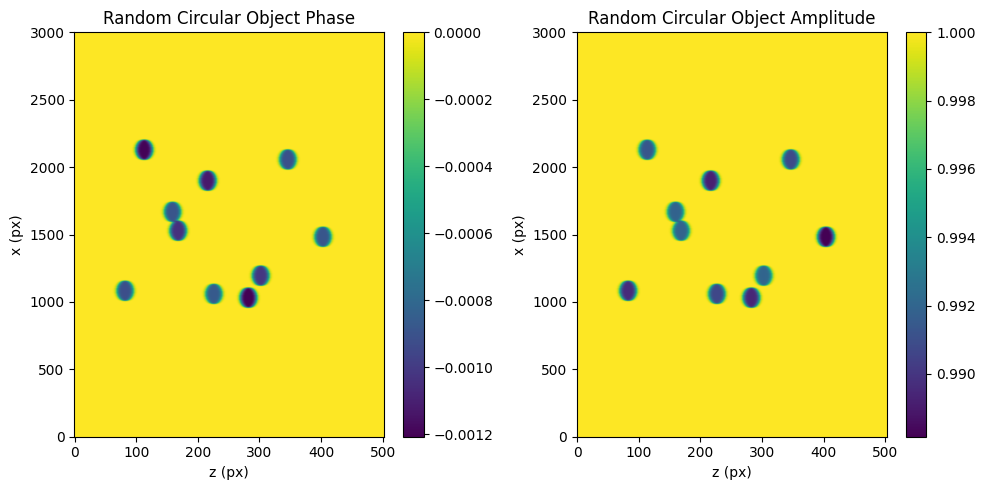

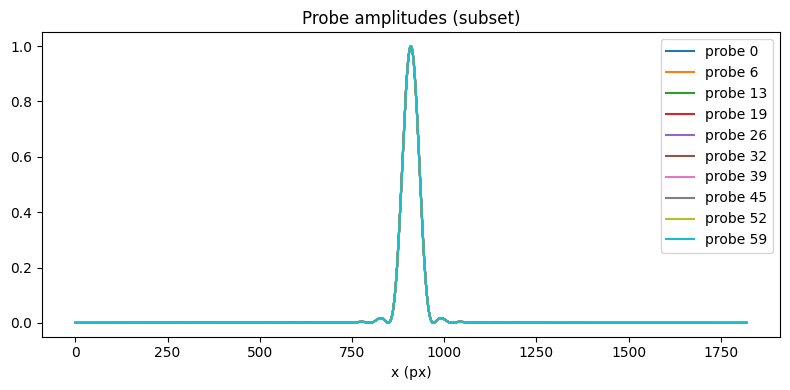

In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a Simultated Ptycho Object ---
# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)

ptycho_object = create_random_circle_object(simulation_space, ptycho_object)


# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

plot_probes(simulation_space, ptycho_probes)

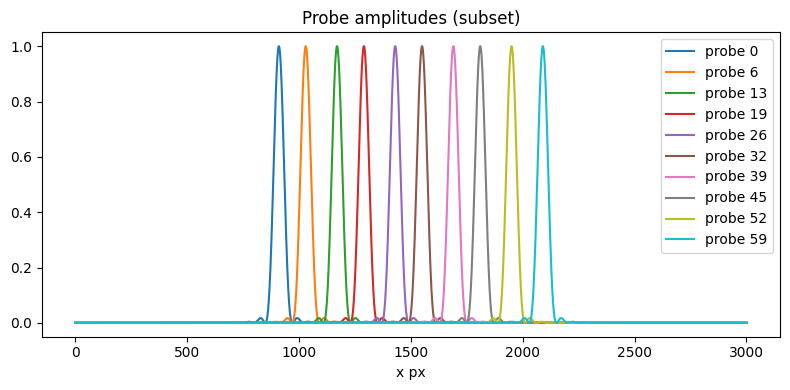

In [5]:
# Full scan view
sim_config_full = SimulationConfig(
    # Probe parameters
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)
simulation_space_full = create_simulation_space(sim_config_full)
# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes_full = create_ptycho_probes(simulation_space_full)

plt.figure(figsize=(8, 4))
plot_num_probes = min(10, simulation_space.total_scans)  # simulation_space.num_probes
probe_indices = np.linspace(
    0, simulation_space.total_scans - 1, plot_num_probes, dtype=int
)

ptycho_probes_full_flat = ptycho_probes_full.reshape(
    (simulation_space_full.total_scans, *simulation_space_full.effective_shape[:-1])
)
for p in probe_indices:
    plt.plot(
        range(simulation_space_full.effective_nx),
        np.abs(ptycho_probes_full_flat[p, :]),
        label=f"probe {p}",
    )
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [6]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type=bc_type
)


# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew = forward_model_pwe.get_exit_waves(u_pwe)
data = forward_model_pwe.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

Forward model creation and solving time: 51.61 seconds.



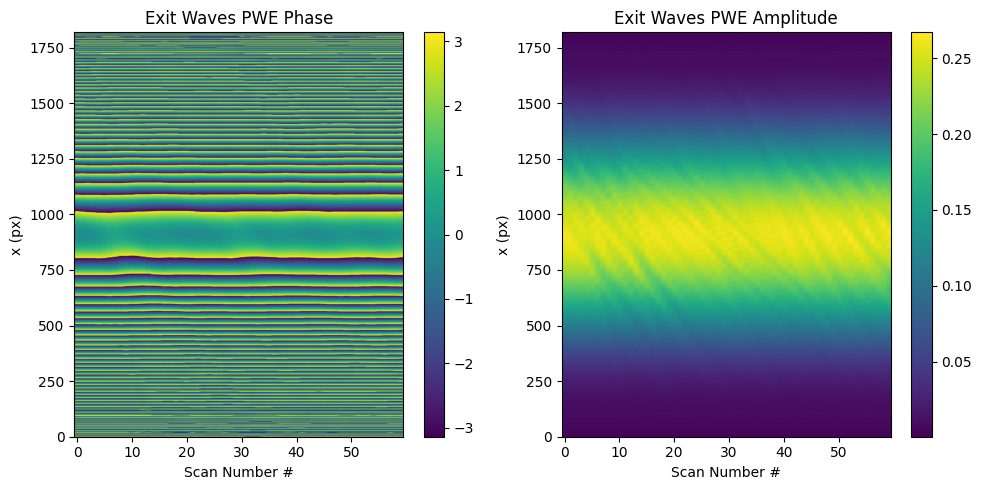

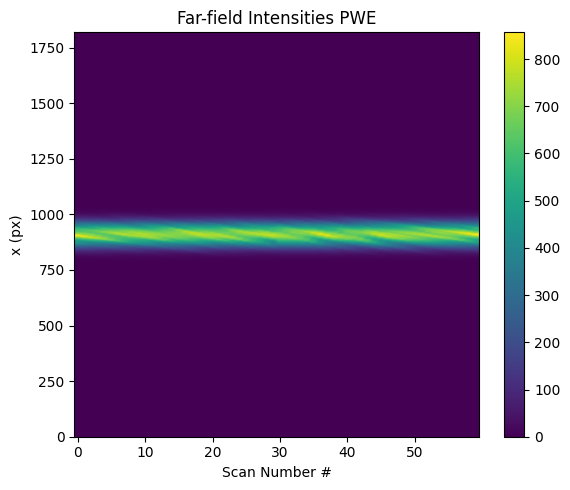

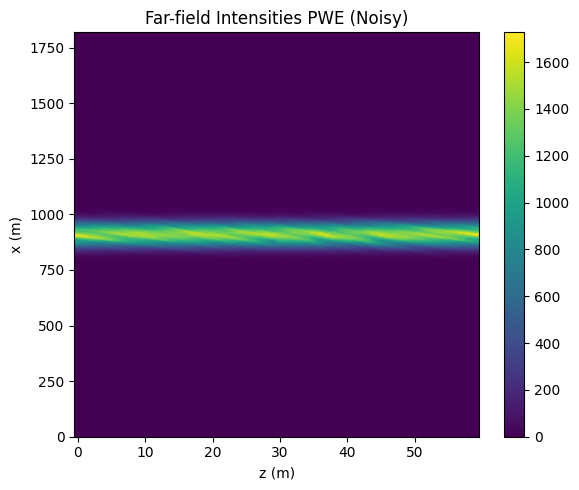

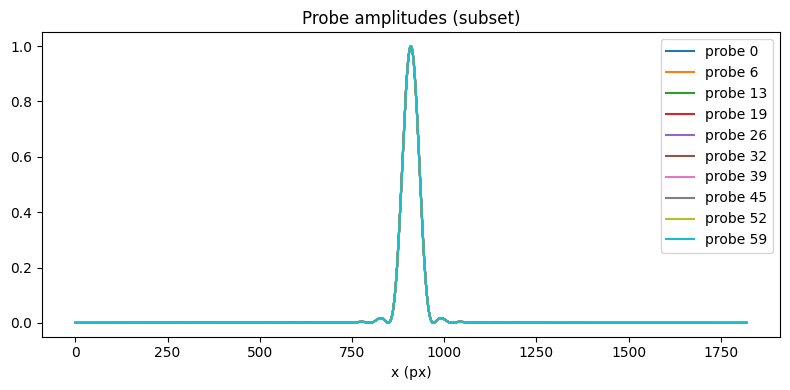

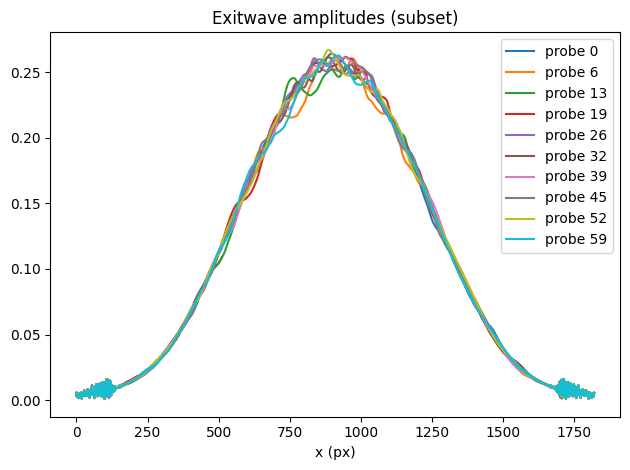

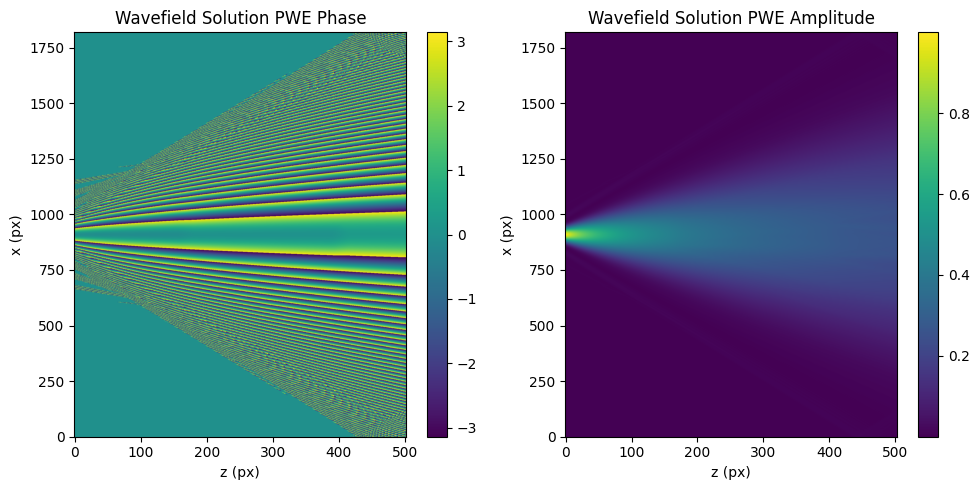

In [7]:
plot_forward_results(simulation_space, data=data, exitwaves=data_ew, solution=u_pwe)

In [ ]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_empty = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type=bc_type
)

# Iterative solution
u_pwe_empty = forward_model_pwe_empty.solve(
    n=np.ones_like(ptycho_object.refractive_index)
)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew_empty = forward_model_pwe_empty.get_exit_waves(u_pwe_empty)
data_empty = forward_model_pwe_empty.get_farfield_intensities(
    exit_waves=data_ew_empty, poisson_noise=False
)

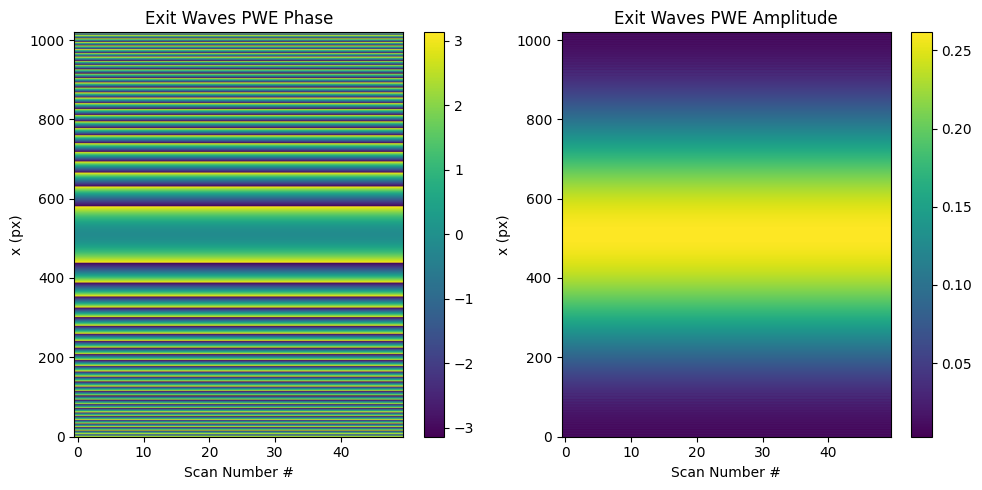

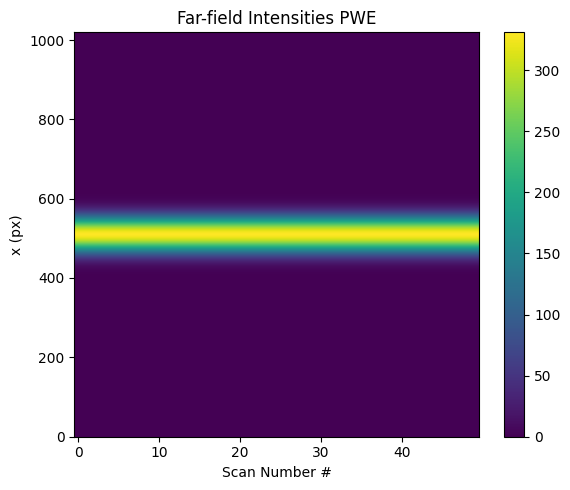

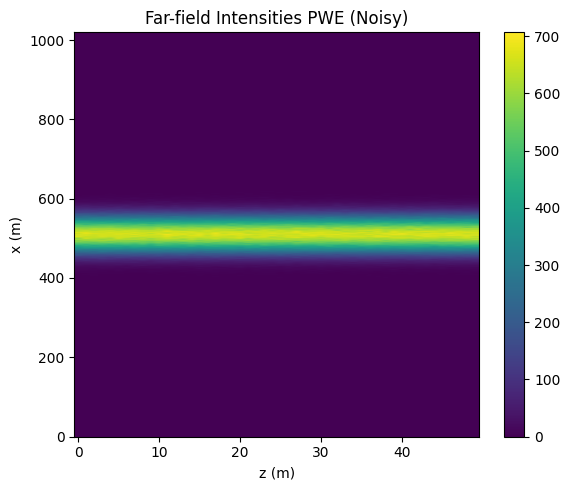

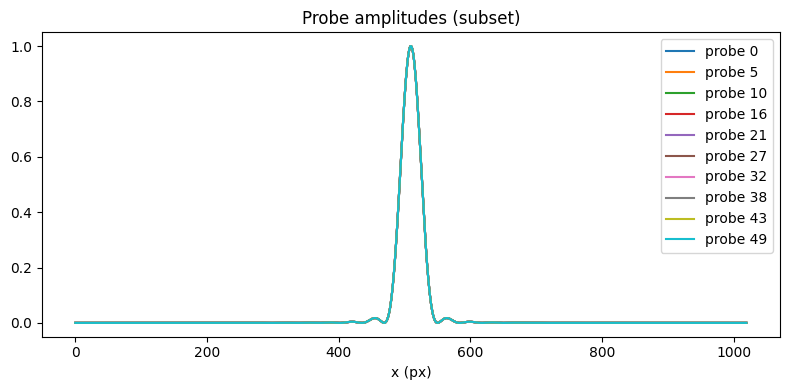

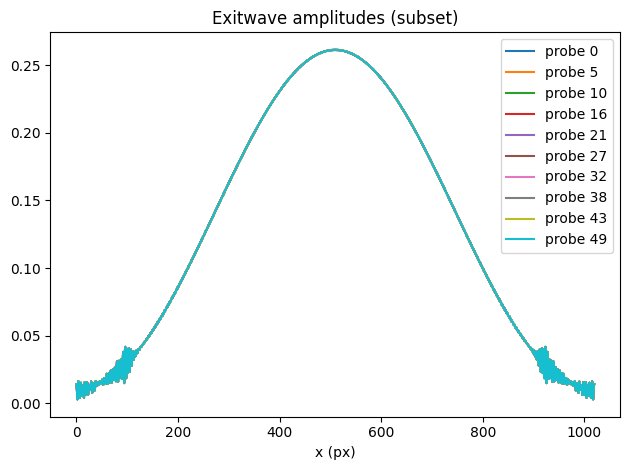

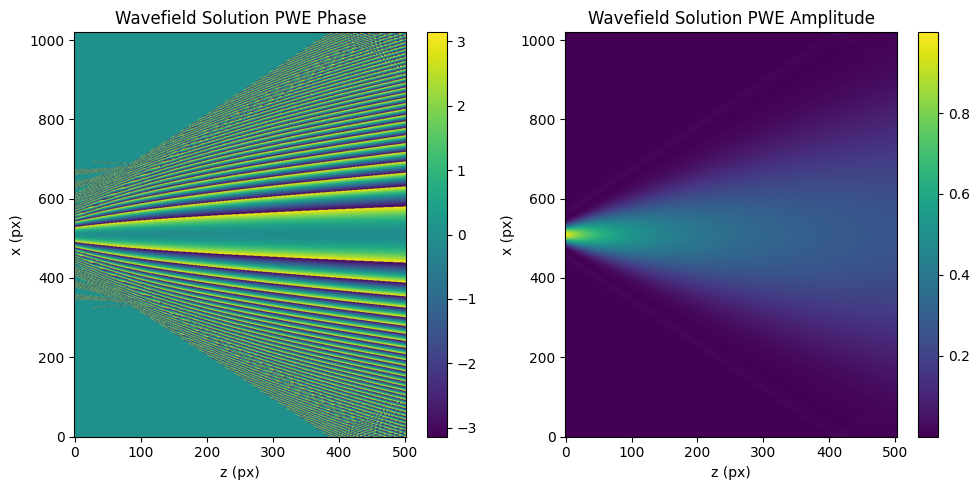

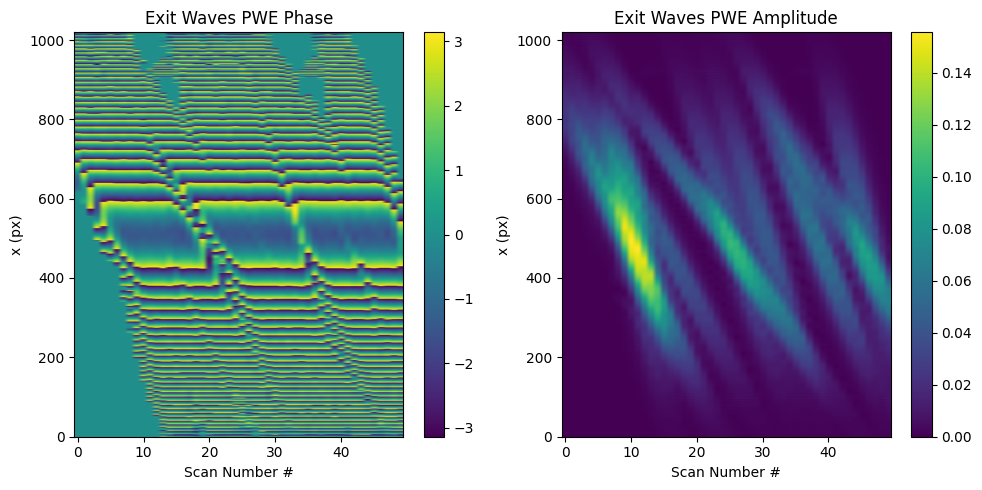

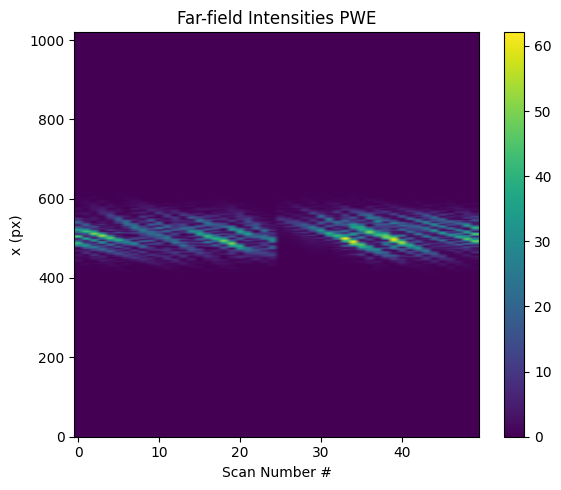

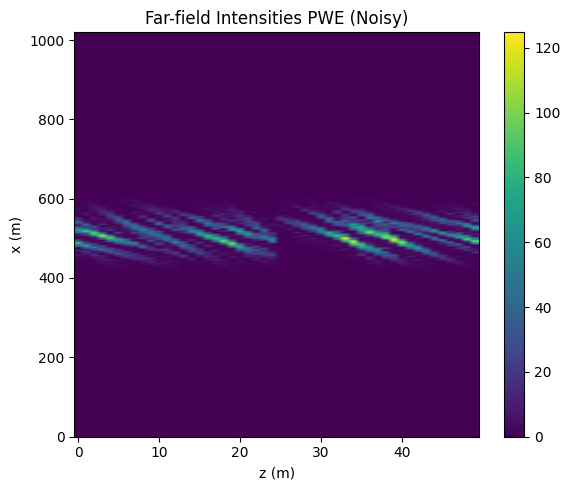

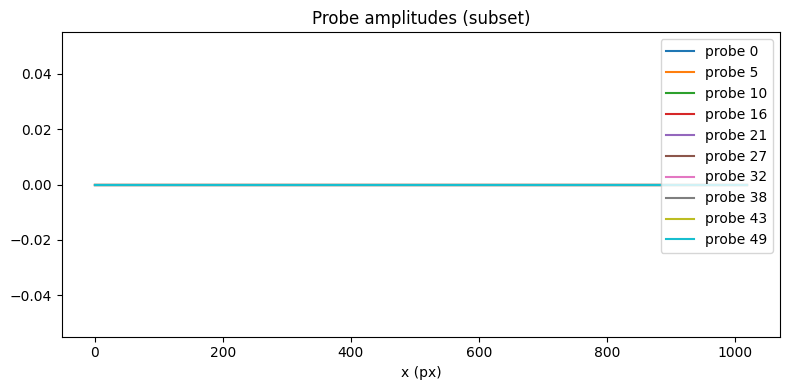

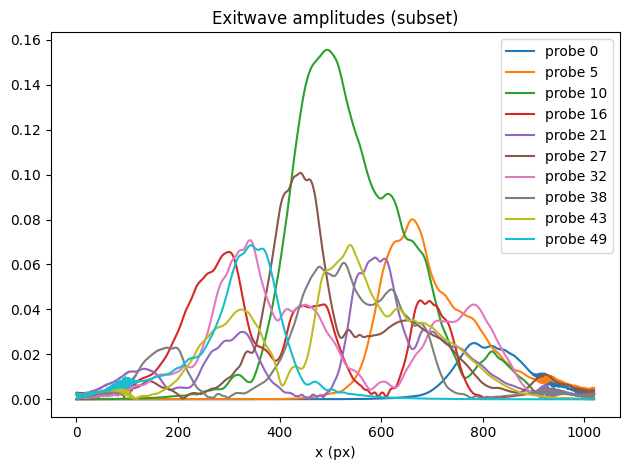

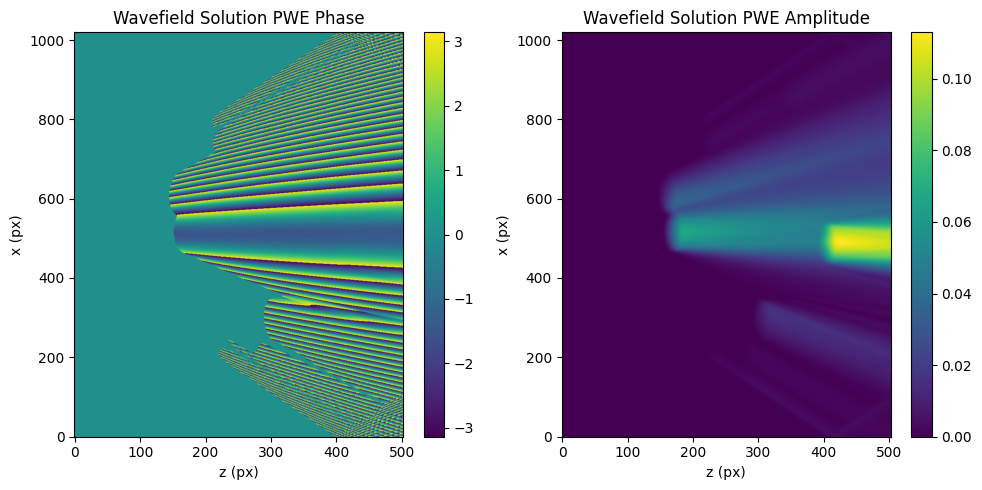

In [ ]:
plot_forward_results(
    simulation_space, data=data_empty, exitwaves=data_ew_empty, solution=u_pwe_empty
)

plot_forward_results(
    simulation_space,
    data=data_empty - data,
    exitwaves=data_ew_empty - data_ew,
    solution=u_pwe_empty - u_pwe,
)